In [1]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pathlib import Path
import os
import time
import datetime
import yaml
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import logging

from tqdm.notebook import tqdm

import volpick.model.models as models
import seisbench.models as sbm
import seisbench.generate as sbg
from volpick.model.utils import load_best_model_from_base_dir,load_best_model
import seisbench.data as sbd
from volpick.model.generate_eval_targets import generate_task0, generate_task1, generate_task23

from volpick.model.models import phase_dict
from volpick.model.eval_taks0 import evaluate, get_ground_truth, count_TP_FP_FN, compute_residuals, calculate_precision_recall_F1score, eval_task0, opt_prob_metrics, collect_task0_results,collect_task0_results_dev,opt_prob_metrics_dev
from volpick.model.eval_taks123 import eval_tasks123,collect_task123_results

import json

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from scipy.stats import rankdata

In [4]:
phase_dict

{'trace_p_arrival_sample': 'P',
 'trace_P_arrival_sample': 'P',
 'trace_s_arrival_sample': 'S',
 'trace_S_arrival_sample': 'S'}

In [5]:
def _identify_instance_dataset_border(task_targets):
    """
    Calculates the dataset border between Signal and Noise for instance,
    assuming it is the only place where the bucket number does not increase
    """
    buckets = task_targets["trace_name"].apply(lambda x: int(x.split("$")[0][6:]))

    last_bucket = 0
    for i, bucket in enumerate(buckets):
        if bucket < last_bucket:
            return i
        last_bucket = bucket

# Load dataset

In [5]:
data_stead = sbd.STEAD(
    sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="full"
)

In [7]:
print(len(data_stead))
print(len(data_stead.dev()))
print(len(data_stead.test()))

1265657
63283
126566


In [6]:
targets_path = Path("/home/zhongyiyuan/volpick/model_training/Eval_targets/stead")
try:
    targets_path.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets/stead exists


In [12]:
[x for x in list(data_stead.metadata.columns) if x.endswith("arrival_sample")]

['trace_p_arrival_sample', 'trace_s_arrival_sample']

In [13]:
phase_dict["trace_S_arrival_sample"]

'S'

In [14]:
replace_if_exist = False
generate_task0(
    dataset=data_stead,
    output=targets_path,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=False,
    replace_if_exist=replace_if_exist,
)
generate_task1(
    dataset=data_stead,
    output=targets_path,
    sampling_rate=100,
    noise_before_events=False,
    replace_if_exist=replace_if_exist,
)
generate_task23(
    dataset=data_stead,
    output=targets_path,
    sampling_rate=100,
    replace_if_exist=replace_if_exist,
)

  0%|          | 0/1265657 [00:00<?, ?it/s]

100%|██████████| 1265657/1265657 [05:54<00:00, 3569.10it/s]


In [ ]:
# split = data_instance.get_split("dev")
# logging.warning("Overwriting noise trace_names to allow correct identification")
# # Replace trace names for noise entries
# split._metadata["trace_name"].values[-len(split.datasets[-1]) :] = split._metadata[
#     "trace_name"
# ][-len(split.datasets[-1]) :].apply(lambda x: "noise_" + x)
# split._build_trace_name_to_idx_dict()

# logging.warning(f"Starting set {'dev'}")
# split.preload_waveforms(pbar=True)

# Load model

In [3]:
vol_eqt = sbm.EQTransformer.from_pretrained("volpick")
vol_eqt.cuda()
vol_pn = sbm.PhaseNet.from_pretrained("volpick")
vol_pn.cuda()
print(vol_eqt.labels)
print(vol_pn.labels)
print(vol_eqt.norm)
print(vol_pn.norm)
print(vol_eqt.device)
print(vol_pn.device)
org_eqt = sbm.EQTransformer.from_pretrained("original")
org_pn = sbm.PhaseNet.from_pretrained("original")
org_eqt.cuda()
org_pn.cuda()
print(org_eqt.labels)
print(org_pn.labels)
print(org_eqt.norm)
print(org_pn.norm)
print(org_eqt.device)
print(org_pn.device)

eqt_instance = sbm.EQTransformer.from_pretrained("instance")
pn_instance = sbm.PhaseNet.from_pretrained("instance")
eqt_instance.cuda()
pn_instance.cuda()
print(eqt_instance.labels)
print(pn_instance.labels)
print(eqt_instance.norm)
print(pn_instance.norm)
print(eqt_instance.device)
print(pn_instance.device)

['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0
['Detection', 'P', 'S']
NPS
std
std
cuda:0
cuda:0
['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0


In [20]:
data_stead["trace_p_arrival_sample"]

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
           ...  
1265652    400.0
1265653    600.0
1265654    500.0
1265655    500.0
1265656    500.0
Name: trace_p_arrival_sample, Length: 1265657, dtype: float64

In [21]:
data_stead["trace_s_arrival_sample"]

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
           ...  
1265652    615.0
1265653    867.0
1265654    737.0
1265655    716.0
1265656    750.0
Name: trace_s_arrival_sample, Length: 1265657, dtype: float64

# Tune threshold on the validation set

In [22]:
model_dict = {
    "vol_eqt": vol_eqt,
    "vol_pn": vol_pn,
    "org_eqt": org_eqt,
    "org_pn": org_pn,
    "int_eqt": eqt_instance,
    "int_pn": pn_instance,
}

In [23]:
targets_path.name

'stead'

In [24]:
np.arange(0.01, 0.1, 0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

In [26]:
print(targets_path)
tp_thre = 0.5
target_path_list = [targets_path]
dataset_list = [data_stead]
for model_name, model in model_dict.items():
    print(model_name)
    eval_task0(
        dev_test_set=data_stead,
        model=model,
        exp_name=model_name,
        targets_path=targets_path,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_STEAD",
        prob_thres=np.arange(0.01, 0.43, 0.01),
        # prob_thres=np.array(
        #     [
        #         0.001,
        #         0.005,
        #         0.01,
        #         0.02,
        #         0.03,
        #         0.04,
        #         0.05,
        #         0.06,
        #         0.07,
        #         0.08,
        #         0.09,
        #         0.43,
        #         0.44,
        #         0.45,
        #         0.46,
        #         0.47,
        #         0.48,
        #         0.49,
        #         0.50,
        #         0.51,
        #     ]
        # ),
        # prob_thres=np.array([0.58, 0.59, 0.60, 0.61]),
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["dev"],
        # sets=["train", "dev","test"],
        append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Eval_targets/stead
vol_eqt
/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0/vol_eqt exists
Starting set: dev


Preloading waveforms: 100%|██████████| 63283/63283 [00:00<00:00, 334255.32it/s]


Number of examples in dev: 63279
51506 earthquake traces
11773 noise traces
Probability threshold: 0.010
Probability threshold: 0.020
Probability threshold: 0.030
Probability threshold: 0.040
Probability threshold: 0.050
Probability threshold: 0.060
Probability threshold: 0.070
Probability threshold: 0.080
Probability threshold: 0.090
Probability threshold: 0.100
Probability threshold: 0.110
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.

Preloading waveforms: 100%|██████████| 63283/63283 [00:00<00:00, 352027.18it/s]


Number of examples in dev: 63279
51506 earthquake traces
11773 noise traces
Probability threshold: 0.010
Probability threshold: 0.020
Probability threshold: 0.030
Probability threshold: 0.040
Probability threshold: 0.050
Probability threshold: 0.060
Probability threshold: 0.070
Probability threshold: 0.080
Probability threshold: 0.090
Probability threshold: 0.100
Probability threshold: 0.110
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.

Preloading waveforms: 100%|██████████| 63283/63283 [00:00<00:00, 353691.03it/s]


Number of examples in dev: 63279
51506 earthquake traces
11773 noise traces
Probability threshold: 0.010
Probability threshold: 0.020
Probability threshold: 0.030
Probability threshold: 0.040
Probability threshold: 0.050
Probability threshold: 0.060
Probability threshold: 0.070
Probability threshold: 0.080
Probability threshold: 0.090
Probability threshold: 0.100
Probability threshold: 0.110
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.

Preloading waveforms: 100%|██████████| 63283/63283 [00:00<00:00, 346413.80it/s]


Number of examples in dev: 63279
51506 earthquake traces
11773 noise traces
Probability threshold: 0.010
Probability threshold: 0.020
Probability threshold: 0.030
Probability threshold: 0.040
Probability threshold: 0.050
Probability threshold: 0.060
Probability threshold: 0.070
Probability threshold: 0.080
Probability threshold: 0.090
Probability threshold: 0.100
Probability threshold: 0.110
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.

Preloading waveforms: 100%|██████████| 63283/63283 [00:00<00:00, 354284.45it/s]


Number of examples in dev: 63279
51506 earthquake traces
11773 noise traces
Probability threshold: 0.010
Probability threshold: 0.020
Probability threshold: 0.030
Probability threshold: 0.040
Probability threshold: 0.050
Probability threshold: 0.060
Probability threshold: 0.070
Probability threshold: 0.080
Probability threshold: 0.090
Probability threshold: 0.100
Probability threshold: 0.110
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.

Preloading waveforms: 100%|██████████| 63283/63283 [00:00<00:00, 355623.03it/s]


Number of examples in dev: 63279
51506 earthquake traces
11773 noise traces
Probability threshold: 0.010
Probability threshold: 0.020
Probability threshold: 0.030
Probability threshold: 0.040
Probability threshold: 0.050
Probability threshold: 0.060
Probability threshold: 0.070
Probability threshold: 0.080
Probability threshold: 0.090
Probability threshold: 0.100
Probability threshold: 0.110
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.

In [28]:
model_pred_save_path = Path(
    "/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0"
)
stats_list = []
for pred_dir in model_pred_save_path.iterdir():
    if pred_dir.is_dir():
        print(pred_dir)
        stats = opt_prob_metrics_dev(pred_dir)
        stats_list.append(stats)
df = pd.DataFrame(stats_list)
df.to_csv(model_pred_save_path / "optimal_threshold_dev.csv", index=False)
df

/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0/vol_eqt
/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0/int_pn
/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0/org_eqt
/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0/vol_pn
/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0/org_pn
/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0/int_eqt


,exp_name,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,dev_p_recall,dev_p_F1score,...,dev_s_modified_std,dev_s_modified_RMSE,dev_s_modified_MAE,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2
0,vol_eqt,0.5,0.27,0.34,48524.0,2171.0,2982.0,0.957175,0.942104,0.949580,...,0.195231,0.195342,0.107114,0.05200,-0.009070,-0.010000,0.154436,0.154701,0.093908,0.050000
1,int_pn,0.5,0.25,0.06,48941.0,2411.0,2565.0,0.953050,0.950200,0.951623,...,0.212307,0.224890,0.128868,0.05000,-0.066149,-0.050000,0.157720,0.171028,0.109302,0.050000
2,org_eqt,0.5,0.32,0.13,51040.0,623.0,466.0,0.987941,0.990953,0.989445,...,0.156689,0.157024,0.079722,0.03000,0.009660,0.000000,0.146839,0.147155,0.076890,0.030000
3,vol_pn,0.5,0.40,0.36,49694.0,1565.0,1812.0,0.969469,0.964820,0.967139,...,0.182746,0.183862,0.100470,0.04400,-0.021396,-0.024895,0.155745,0.157206,0.092006,0.044895
4,org_pn,0.5,0.42,0.33,48579.0,3003.0,2927.0,0.941782,0.943172,0.942476,...,0.234931,0.239671,0.127508,0.04165,0.052428,0.039940,0.160782,0.169113,0.100809,0.039940
5,int_eqt,0.5,0.23,0.10,48611.0,1924.0,2895.0,0.961927,0.943793,0.952774,...,0.232849,0.235235,0.133344,0.06584,-0.031448,-0.024150,0.164052,0.167037,0.108176,0.064150


In [29]:
for i, exp_name in enumerate(model_dict):
    print(exp_name)

vol_eqt
vol_pn
org_eqt
org_pn
int_eqt
int_pn


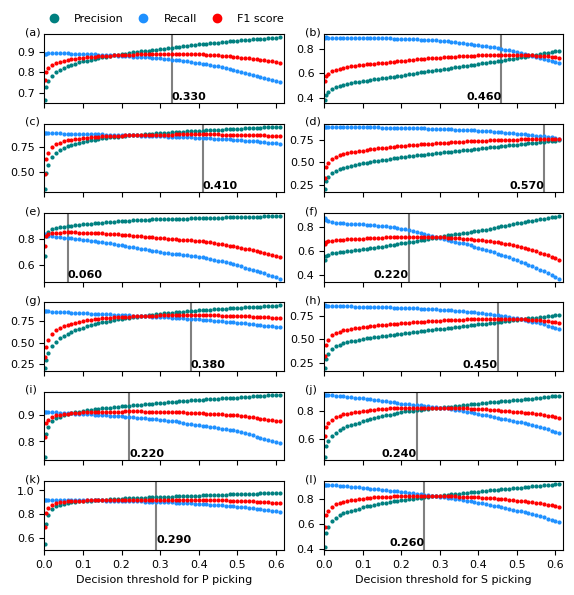

In [30]:
# df_org_models_expnames = [
#     "EQTransformer_org",
#     "EQTransformer_org_instance",
#     "PhaseNet_org",
#     "PhaseNet_org_instance",
# ]

fts = 8
cm = 1 / 2.54
fig, axs = plt.subplots(6, 2, figsize=(17 * cm, 17 * cm), sharex=True)
plt.subplots_adjust(wspace=0.17, hspace=0.30)
colors = ["teal", "dodgerblue", "red"]
metrics_labels = {"precision": "Precision", "recall": "Recall", "F1score": "F1 score"}
ylabels_dict = {
    "EQTransformer_org": "Original EQTransformer",
    "EQTransformer_org_instance": "EQTransformer \ntrained on INSTANCE",
    "PhaseNet_org_instance": "PhaseNet \ntrained on INSTANCE",
    "PhaseNet_org": "Original PhaseNet",
}

for i, exp_name in enumerate(model_dict):
    dev_result = pd.read_csv(
        f"/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/{exp_name}/dev_metrics.csv"
    )
    prob_thre = dev_result["prob_thre"]
    for j, phase in enumerate(["p", "s"]):
        ax = axs[i][j]
        # precision = pn_dev_result[f"{phase}_precision"]
        # recall = pn_dev_result[f"{phase}_recall"]
        # F1score = pn_dev_result[f"{phase}_F1score"]
        # f1score = dev_result[f"{phase}_F1score"]
        f1score = 1 / (
            1 / dev_result[f"{phase}_recall"] + 1 / dev_result[f"{phase}_precision"]
        )
        opt_thre = prob_thre[np.argmax(f1score)]
        ax.axvline(opt_thre, color="grey")

        for k, metric_name in enumerate(["precision", "recall", "F1score"]):
            metric_value = dev_result[f"{phase}_{metric_name}"]
            if opt_thre < 0.05:
                plot_func = ax.semilogx
            else:
                plot_func = ax.plot
            plot_func(
                prob_thre,
                metric_value,
                color=colors[k],
                label=metrics_labels[metric_name],
                markersize=4,
                marker=".",
                linestyle="",
            )
            ax.tick_params(labelsize=fts)
        ax.text(
            opt_thre,
            # 0.88,
            ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.02,
            f"{opt_thre:.3f}",
            verticalalignment="bottom",
            horizontalalignment=["left", "right"][j],
            # transform=ax.transAxes,
            fontsize=fts,
            weight="bold",
            color="black",
        )
        ax.set_xlim([0, 0.62])
        # print(opt_thre)
    # axs[i][0].set_ylabel(ylabels_dict[exp_name], fontsize=fts)
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(-0.05, 1, 0.8, 0.5),
    frameon=False,
    markerscale=3,
    fontsize=fts,
    ncols=3,
    columnspacing=0.8,
)
axs[-1][0].set_ylim([0.5, 1.08])
axs[-1][0].set_xlabel("Decision threshold for P picking", fontsize=fts)
axs[-1][1].set_xlabel("Decision threshold for S picking", fontsize=fts)
for i, ax in enumerate(axs.flat):
    ax.text(
        -0.08,
        1.1,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
plt.savefig("threshold_tuning_STEAD.eps", dpi=600, bbox_inches="tight", pad_inches=0)

# Evaluation on the test set

In [14]:
model_pred_save_path = Path(
    "/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0"
)
df = pd.read_csv(model_pred_save_path / "optimal_threshold_dev.csv")
df

,exp_name,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,dev_p_recall,dev_p_F1score,...,dev_s_modified_std,dev_s_modified_RMSE,dev_s_modified_MAE,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2
0,vol_eqt,0.5,0.27,0.34,48524.0,2171.0,2982.0,0.957175,0.942104,0.949580,...,0.195231,0.195342,0.107114,0.05200,-0.009070,-0.010000,0.154436,0.154701,0.093908,0.050000
1,int_pn,0.5,0.25,0.06,48941.0,2411.0,2565.0,0.953050,0.950200,0.951623,...,0.212307,0.224890,0.128868,0.05000,-0.066149,-0.050000,0.157720,0.171028,0.109302,0.050000
2,org_eqt,0.5,0.32,0.13,51040.0,623.0,466.0,0.987941,0.990953,0.989445,...,0.156689,0.157024,0.079722,0.03000,0.009660,0.000000,0.146839,0.147155,0.076890,0.030000
3,vol_pn,0.5,0.40,0.36,49694.0,1565.0,1812.0,0.969469,0.964820,0.967139,...,0.182746,0.183862,0.100470,0.04400,-0.021396,-0.024895,0.155745,0.157206,0.092006,0.044895
4,org_pn,0.5,0.42,0.33,48579.0,3003.0,2927.0,0.941782,0.943172,0.942476,...,0.234931,0.239671,0.127508,0.04165,0.052428,0.039940,0.160782,0.169113,0.100809,0.039940
5,int_eqt,0.5,0.23,0.10,48611.0,1924.0,2895.0,0.961927,0.943793,0.952774,...,0.232849,0.235235,0.133344,0.06584,-0.031448,-0.024150,0.164052,0.167037,0.108176,0.064150


In [4]:
model_dict = {
    "vol_eqt": vol_eqt,
    "vol_pn": vol_pn,
    "org_eqt": org_eqt,
    "org_pn": org_pn,
    "int_eqt": eqt_instance,
    "int_pn": pn_instance,
}

In [8]:
prob_thres_dict = {
    "vol_eqt": np.array([0.27, 0.34]),
    "vol_pn": np.array([0.40, 0.36]),
    "org_eqt": np.array([0.32, 0.13]),
    "org_pn": np.array([0.42, 0.33]),
    "int_eqt": np.array([0.23, 0.1]),
    "int_pn": np.array([0.25, 0.06]),
}

In [34]:
df

,exp_name,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,dev_p_recall,dev_p_F1score,...,dev_s_modified_std,dev_s_modified_RMSE,dev_s_modified_MAE,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2
0,vol_eqt,0.5,0.27,0.34,48524.0,2171.0,2982.0,0.957175,0.942104,0.949580,...,0.195231,0.195342,0.107114,0.05200,-0.009070,-0.010000,0.154436,0.154701,0.093908,0.050000
1,int_pn,0.5,0.25,0.06,48941.0,2411.0,2565.0,0.953050,0.950200,0.951623,...,0.212307,0.224890,0.128868,0.05000,-0.066149,-0.050000,0.157720,0.171028,0.109302,0.050000
2,org_eqt,0.5,0.32,0.13,51040.0,623.0,466.0,0.987941,0.990953,0.989445,...,0.156689,0.157024,0.079722,0.03000,0.009660,0.000000,0.146839,0.147155,0.076890,0.030000
3,vol_pn,0.5,0.40,0.36,49694.0,1565.0,1812.0,0.969469,0.964820,0.967139,...,0.182746,0.183862,0.100470,0.04400,-0.021396,-0.024895,0.155745,0.157206,0.092006,0.044895
4,org_pn,0.5,0.42,0.33,48579.0,3003.0,2927.0,0.941782,0.943172,0.942476,...,0.234931,0.239671,0.127508,0.04165,0.052428,0.039940,0.160782,0.169113,0.100809,0.039940
5,int_eqt,0.5,0.23,0.10,48611.0,1924.0,2895.0,0.961927,0.943793,0.952774,...,0.232849,0.235235,0.133344,0.06584,-0.031448,-0.024150,0.164052,0.167037,0.108176,0.064150


In [105]:
targets_path

PosixPath('/home/zhongyiyuan/volpick/model_training/Eval_targets/instance')

In [10]:
tp_thre = 0.5
for model_name, model in model_dict.items():
    print(model_name)
    eval_task0(
        dev_test_set=data_stead,
        model=model,
        exp_name=model_name,
        targets_path=targets_path,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_STEAD",
        prob_thres=prob_thres_dict[model_name],
        num_workers=16,
        batchsize=1024,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )
    # eval_task0(
    #     dev_test_set=data_instance,
    #     model=model,
    #     exp_name=model_name,
    #     targets_path=targets_path,
    #     root_save_dir="/home/zhongyiyuan/volpick/model_training/Noise_specificity",
    #     # prob_thres=np.array([0.27,0.3,0.32]),
    #     # prob_thres=np.array([0.21,0.22,0.23,0.24,0.25,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
    #     prob_thres=prob_thres_dict[model_name],
    #     num_workers=32,
    #     batchsize=1024,
    #     num_test_run=-1,
    #     output_remark="pred",
    #     sets=["test"],
    #     # sets=["test"],
    #     data_norm_type=model.norm,
    # )

vol_eqt
/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0/vol_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 126566/126566 [00:38<00:00, 3297.88it/s]


Number of examples in test: 126563
103037 earthquake traces
23526 noise traces
Probability threshold: 0.270
Probability threshold: 0.340
vol_pn
/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0/vol_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 126566/126566 [00:35<00:00, 3540.16it/s]


Number of examples in test: 126563
103037 earthquake traces
23526 noise traces
Probability threshold: 0.400
Probability threshold: 0.360
org_eqt
/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0/org_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 126566/126566 [00:19<00:00, 6461.39it/s]


Number of examples in test: 126563
103037 earthquake traces
23526 noise traces
Probability threshold: 0.320
Probability threshold: 0.130
org_pn
/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0/org_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 126566/126566 [00:04<00:00, 25454.01it/s]


Number of examples in test: 126563
103037 earthquake traces
23526 noise traces
Probability threshold: 0.420
Probability threshold: 0.330
int_eqt
/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0/int_eqt exists
Starting set: test


Preloading waveforms: 100%|██████████| 126566/126566 [00:05<00:00, 24976.88it/s]


Number of examples in test: 126563
103037 earthquake traces
23526 noise traces
Probability threshold: 0.230
Probability threshold: 0.100
int_pn
/home/zhongyiyuan/volpick/model_training/Test_STEAD/stead_pred/task0/int_pn exists
Starting set: test


Preloading waveforms: 100%|██████████| 126566/126566 [00:05<00:00, 24654.34it/s]


Number of examples in test: 126563
103037 earthquake traces
23526 noise traces
Probability threshold: 0.250
Probability threshold: 0.060


# Plot

In [15]:
df

,exp_name,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,dev_p_recall,dev_p_F1score,...,dev_s_modified_std,dev_s_modified_RMSE,dev_s_modified_MAE,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2
0,vol_eqt,0.5,0.27,0.34,48524.0,2171.0,2982.0,0.957175,0.942104,0.949580,...,0.195231,0.195342,0.107114,0.05200,-0.009070,-0.010000,0.154436,0.154701,0.093908,0.050000
1,int_pn,0.5,0.25,0.06,48941.0,2411.0,2565.0,0.953050,0.950200,0.951623,...,0.212307,0.224890,0.128868,0.05000,-0.066149,-0.050000,0.157720,0.171028,0.109302,0.050000
2,org_eqt,0.5,0.32,0.13,51040.0,623.0,466.0,0.987941,0.990953,0.989445,...,0.156689,0.157024,0.079722,0.03000,0.009660,0.000000,0.146839,0.147155,0.076890,0.030000
3,vol_pn,0.5,0.40,0.36,49694.0,1565.0,1812.0,0.969469,0.964820,0.967139,...,0.182746,0.183862,0.100470,0.04400,-0.021396,-0.024895,0.155745,0.157206,0.092006,0.044895
4,org_pn,0.5,0.42,0.33,48579.0,3003.0,2927.0,0.941782,0.943172,0.942476,...,0.234931,0.239671,0.127508,0.04165,0.052428,0.039940,0.160782,0.169113,0.100809,0.039940
5,int_eqt,0.5,0.23,0.10,48611.0,1924.0,2895.0,0.961927,0.943793,0.952774,...,0.232849,0.235235,0.133344,0.06584,-0.031448,-0.024150,0.164052,0.167037,0.108176,0.064150


In [17]:
p_thre_dict = {
    "vol_eqt": 0.27,
    "vol_pn": 0.40,
    "org_eqt": 0.32,
    "org_pn": 0.42,
    "int_eqt": 0.23,
    "int_pn": 0.25,
}

s_thre_dict = {
    "vol_eqt": 0.34,
    "vol_pn": 0.36,
    "org_eqt": 0.13,
    "org_pn": 0.33,
    "int_eqt": 0.1,
    "int_pn": 0.06,
}

In [19]:
pred_dirs = ["org_pn", "org_eqt", "int_pn", "int_eqt", "vol_pn", "vol_eqt"]
# data_types_plotted = [
#     "ncedc_vt_pred",
#     "ncedc_lp_pred",
# ]  # ['rg_and_noise_pred','lp_and_noise_pred']
precision_dict = {x: [] for x in pred_dirs}
recall_dict = {x: [] for x in pred_dirs}
f1score_dict = {x: [] for x in pred_dirs}
pred_dir_path = Path("/home/zhongyiyuan/volpick/model_training/Test_STEAD/")

for model_name in pred_dirs:
    # for j, data_type in enumerate(data_types_plotted):
    pred_df = pd.read_csv(
        pred_dir_path / "stead_pred" / "task0" / model_name / "test_metrics.csv"
    )
    p_row = pred_df[np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])].iloc[0]
    s_row = pred_df[np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])].iloc[0]
    assert (
        np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
    ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
    assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

    precision_dict[model_name] = [p_row["p_precision"], s_row["s_precision"]]
    recall_dict[model_name] = [p_row["p_recall"], s_row["s_recall"]]
    f1score_dict[model_name] = [p_row["p_F1score"], s_row["s_F1score"]]

metrics = {"Recall": recall_dict, "Precision": precision_dict, "F1 score": f1score_dict}

In [112]:
metrics

{'Recall': {'org_pn': [0.7754283323940716, 0.7538916593331377],
  'org_eqt': [0.8063455359892169, 0.7653368534272025],
  'int_pn': [0.901914931937416, 0.8334751148919527],
  'int_eqt': [0.892581381702407, 0.8380756820181872],
  'vol_pn': [0.8405598387181111, 0.7803461425638017],
  'vol_eqt': [0.8592879427844365, 0.7994035396499463]},
 'Precision': {'org_pn': [0.8628453029744704, 0.6803635641642216],
  'org_eqt': [0.8960430238038363, 0.6694435060019929],
  'int_pn': [0.9431171647888992, 0.812129613750262],
  'int_eqt': [0.9353517949717048, 0.7983903645433078],
  'vol_pn': [0.9153822792498671, 0.7229229981837699],
  'vol_eqt': [0.9173807463644738, 0.7034261426211453]},
 'F1 score': {'org_pn': [0.8168045678755461, 0.7152428771872863],
  'org_eqt': [0.8488312355509889, 0.7141856703902332],
  'int_pn': [0.9220559956640856, 0.822663925724323],
  'int_eqt': [0.9134662122088226, 0.8177518264889193],
  'vol_pn': [0.8763769296702032, 0.7505378214879375],
  'vol_eqt': [0.8873845969235846, 0.74835

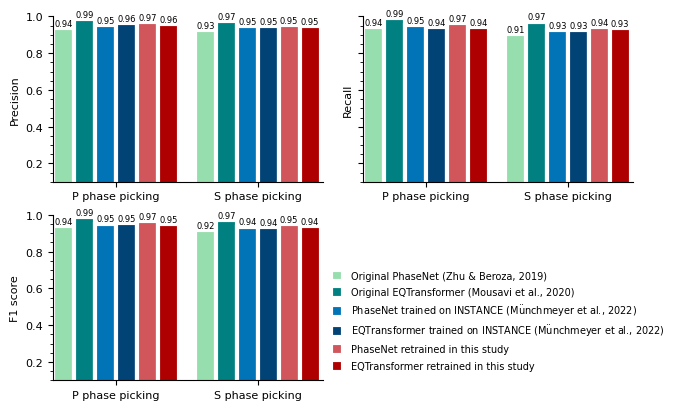

In [21]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    2, 2, figsize=(19 * cm, 12 * cm), sharey="all", squeeze=False
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.2, wspace=0.15)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.2
# x=np.array([0,1.5,3])
width = 0.325  # the width of the bars

metric_names = ["Precision", "Recall", "F1 score"]
colors = [
    (164 / 255, 208 / 255, 80 / 255),
    (84 / 255, 130 / 255, 53 / 255),
    (0 / 255, 176 / 255, 240 / 255),
    (0 / 255, 112 / 255, 192 / 255),
    (255 / 255, 192 / 255, 0 / 255),
    (170 / 255, 80 / 255, 30 / 255),
    # (9 / 255, 80 / 255, 153 / 255),
    # (0 / 255, 112 / 255, 182 / 255),
]
# colors = ["#96DEAE", "#008080", "#0074B7", "#003B73", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#AE0000"]
# colors = ["#6988E7", "#F05C79", "#0074B7", "#DC143C", "#003B73", "#5E091A"]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
# test_set_names = [
#     "Alaska, Hawaii and Japan",
#     "Northern California",
#     "Japan tectonic LPs",
# ]

fts = 8
for i in range(3):
    # for j in range(2):
    # if i == 2 and j == 1:
    #     break
    # if i == 2 and j == 0:
    #     metric_dict = metrics_list[i][metric_names[0]][j]
    #     ax = axs[i][1]
    # else:
    metric_dict = metrics[metric_names[i]]
    ax = axs.flat[i]

    # ax = axs[i][j]

    fmt = "{:.2f}"
    interval = width
    for k, (attribute, value) in enumerate(metric_dict.items()):
        offset = interval * k
        rects = ax.bar(
            x + offset,
            value,
            width,
            label=labels[attribute],
            edgecolor="white",
            color=colors[k],
            linewidth=3,
        )  # ,edgecolor="black",hatch=hatches[k]
        ax.bar_label(rects, padding=0, fmt=fmt, fontsize=fts - 2.0, color="black")
        ax.spines[["right", "top"]].set_visible(False)

    ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
    ax.tick_params(labelsize=fts)
    ax.set_ylim([0.1, 1])
    ax.set_xlim(x[0] - 0.5 * interval, x[-1] + 5.6 * interval)
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.set_ylabel(f"{metric_names[i]}", fontsize=fts)
    # axs[i][0].set_ylabel(metric_names[i], fontsize=fts)
    # axs[0][0].set_ylabel(test_set_names[i], fontsize=fts)
    # axs[0][0].text(
    #     0.02,
    #     1.0,
    #     chr(65 + i),
    #     verticalalignment="top",
    #     horizontalalignment="left",
    #     weight="bold",
    #     transform=axs[0][0].transAxes,
    #     fontsize=fts + 3,
    # )
fig.delaxes(axs[1][1])
handles, legend_labels = axs[1][1].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]
# ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
leg = axs[1][0].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=1.2,
    handleheight=1.5,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(1.0, 0, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.8,
)

# axs[0][1].set_title("VT test set", fontsize=fts)
# axs[0][0].set_title("LP test set", fontsize=fts)
plt.savefig("peformance_for_STEAD.eps", dpi=600, bbox_inches="tight", pad_inches=0)